# Calorie-Expenditure Prediction

In [1]:
# Libraries 
import pandas as pd 
import rtoml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Config
with open("pyproject.toml","r",encoding="utf-8") as f:
    toml = rtoml.load(f)

# Data
train = pd.read_csv(toml["config"]["train"])
train_X = train.drop(columns=["Calories"])
train_Y = train[["id","Calories"]]
test_X = pd.read_csv(toml["config"]["test"])
test_Y = pd.read_csv(toml["config"]["sample"])

## 1. EDA

### 1.1 First look

In [3]:
# Visualization of a few rows observations
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


**Variables**:<br>
| NOMBRE | DESCRIPCION  | TIPO | NULOS | CAMBIAR TIPO | 
|------------|--------------|--------------|--------------|------------|
| id | Identificator of the subject | int | NO |  NO |
| sexo | Subject's sex | bin | NO | YES |
| Age | Subject's age (years) | int | NO | NO |
| Height | Subject's height (cm) | float | NO | NO |
| Weight | Subject's weight (kg) | float | NO | NO |
| Duration | Exercice duration (min) | float | NO | NO |
| Heart_Rate | Subject's heart rate (lpm) | float | NO | NO |
| Body_Temp | Subject's boty temperature (ºC) | float | NO | NO |
| Calories | Burnt calories (target) | float | NO | NO |






In [4]:
# Informacion extra
print("Number of rows in train:   ",train.shape[0])
n_train = train.shape[0]
print("Number of rows in test:    ",test_X.shape[0]) 
n_test = test_X.shape[0]
print("Number of features:        ",train.shape[1]-1)
n_features = train.shape[1]-1

Number of rows in train:    750000
Number of rows in test:     250000
Number of features:         8


In [5]:
# Indext change
train.set_index("id",inplace=True)
train_X.set_index("id",inplace=True)
train_Y.set_index("id",inplace=True)
test_X.set_index("id",inplace=True)
test_Y.set_index("id",inplace=True)

In [6]:
# Some observations
train.sample(10)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
506143,male,63,184.0,89.0,20.0,108.0,40.5,186.0
322328,male,39,184.0,91.0,7.0,88.0,39.2,27.0
732371,male,33,170.0,72.0,21.0,102.0,40.7,112.0
125708,male,30,175.0,78.0,15.0,102.0,40.0,80.0
140904,female,50,169.0,66.0,6.0,92.0,39.3,29.0
75535,female,43,154.0,55.0,7.0,85.0,39.2,29.0
340366,male,44,185.0,87.0,19.0,97.0,40.6,107.0
217199,female,62,164.0,67.0,4.0,88.0,39.1,19.0
165046,male,22,189.0,90.0,27.0,107.0,40.6,156.0


In [7]:
# Sex as boolean
print(f"There are {train_X["Sex"].nunique()} classes.")

# 0 male, 1 female
train_X.loc[train_X["Sex"] == "female", "Sex"] = 0
train_X.loc[train_X["Sex"] == "male", "Sex"] = 1
train_X.sample(10)


There are 2 classes.


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
351208,0,37,167.0,63.0,25.0,109.0,40.8
250506,1,20,183.0,83.0,20.0,98.0,40.7
161950,0,73,158.0,59.0,10.0,93.0,39.7
279934,0,20,158.0,54.0,12.0,91.0,40.0
624968,1,32,194.0,94.0,5.0,88.0,39.1
379504,0,62,170.0,65.0,6.0,80.0,39.3
45564,0,24,172.0,69.0,20.0,101.0,40.5
452168,0,44,174.0,72.0,12.0,88.0,40.3
46778,1,26,178.0,82.0,6.0,84.0,39.0


In [8]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In general, all features are within a reasonable range of values. The only weird thing is that the minimum weight is 36 kg, which, taking into consideration that the minimum age is 20 years old, is way too low. However, the minimum height is 126 cm, so maybe there are subjects with achondroplasia. If I’m right, there shouldn’t be any problems with the data, so I’ll work with the dataset ignoring these facts.

### 1.2 Correlations

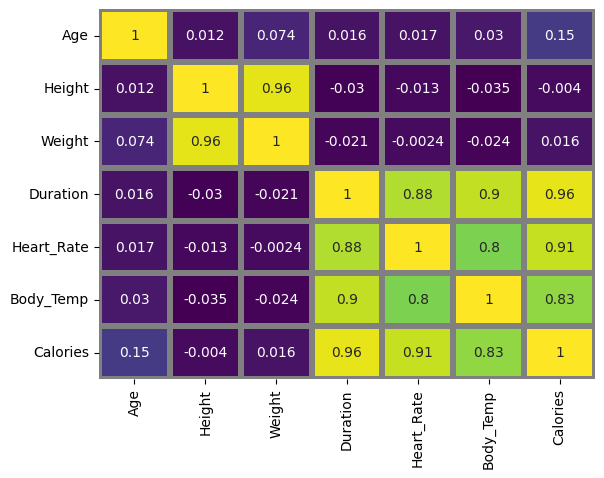

In [9]:
# Correlation matrix
corr_matrix = train.drop(columns=["Sex"]).corr() 

# Plot
sns.heatmap(corr_matrix, annot=True, cmap="viridis", linewidths=4, cbar=False,linecolor="gray")
plt.show()

Remarkable correlations:<br>
- Calories-Duration (0.96): it has sense that the burnt-calories scales linearly with the duration of the exercise (taking into consideration that the intesity of the exercise should be constant).<br>
- Calories-Heart_rate (0.91): more calories burnt equals a higher heart_rate.<br>
- Calories-Boy_temp (0.83): when the body burnt calories generates heat, so no surprises here.<br>
- Weight-Height (0.96): this was predictable too. <br>

1. Maybe the height is not a interesting feature for this prediction. First, weight should be more important in how many calories you burn, because with bodyweight exercises, the bodywieght it's what you move. Also, the correlation height-weight is so high, so height do not give us any extra information.

2. Body_temp, heart_rate and duration has high correlation with burnt-calories, so between them they have it high too. Maybe we cold just use duration in the model. 

### 1.3 Boxplots

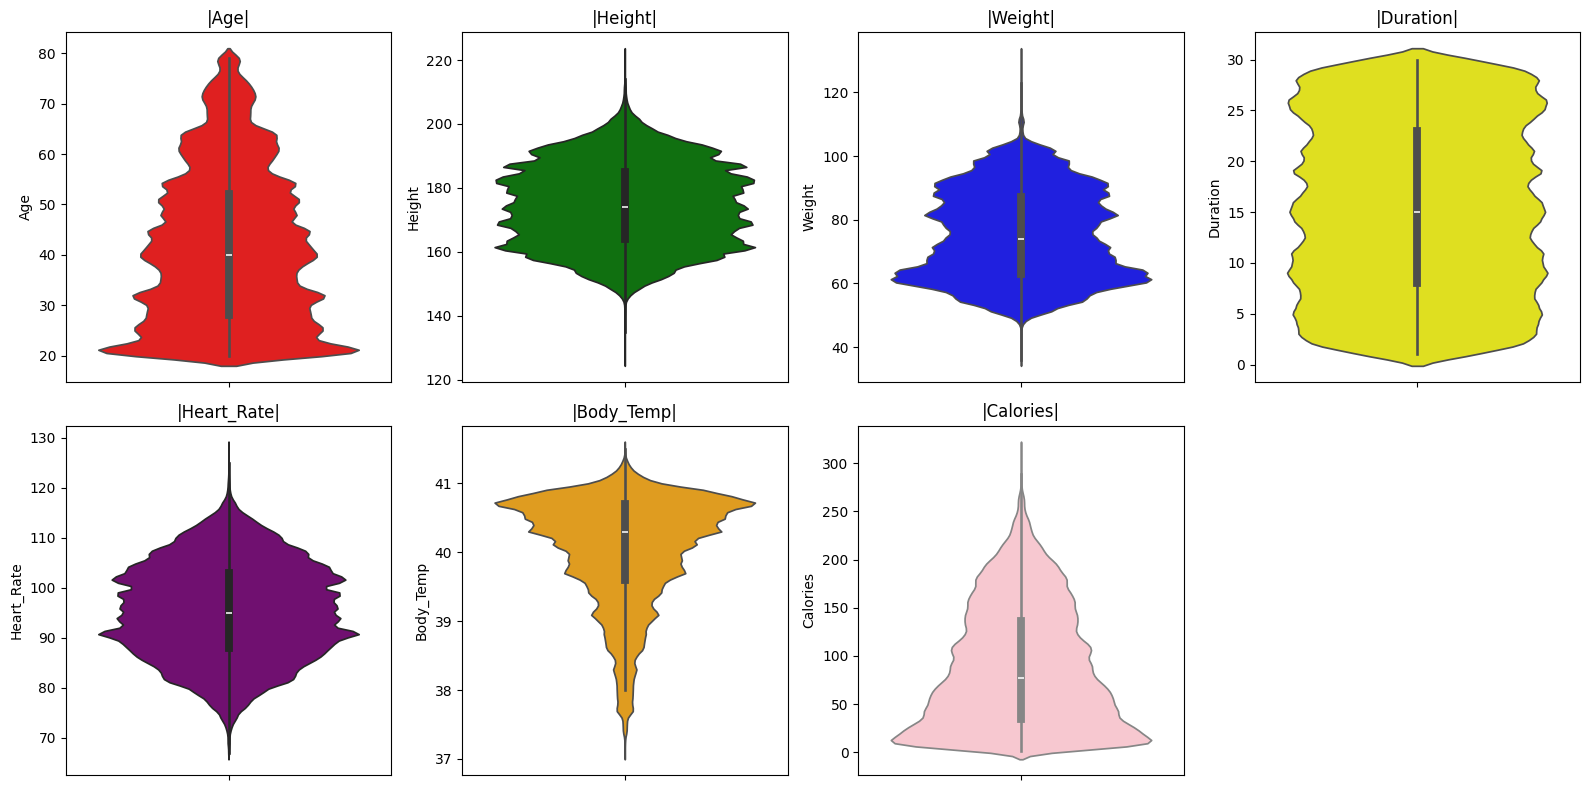

In [10]:
# Figura y subplots
fig, axes = plt.subplots(2,4, figsize=(4*4,2*4))
axes = np.array(axes).reshape(-1)

colors = ["red","green","blue","yellow","purple","orange","pink"]

# Plots
for i, feature in enumerate(train.drop(columns=["Sex"]).columns):
    sns.violinplot(y=train[feature],ax=axes[i], color=colors[i])
    axes[i].set_title(f"|{feature}|")

# Eliminar plots vacios 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are no significant outliers in the data.

## 2. Models

Before making models, we must transform some features.

In [11]:
# Standar scaler
train_X_np = train_X.drop(columns=["Sex"]).to_numpy()
np.set_printoptions(suppress=True)
train_mean_vec = np.mean(train_X_np, axis=0)
train_std_vec = np.std(train_X_np, axis=0)

# Calcule means and std's
print("Means:")
for i,f in enumerate(train_X.drop(columns=["Sex"]).columns):
    print(f"\tFeature '{f}': {train_mean_vec[i]:{".3f"}}")  
    

print("\nStandar deviation:")
for i,f in enumerate(train_X.drop(columns=["Sex"]).columns):
    print(f"\tFeature '{f}': {train_std_vec[i]:{".3f"}}")  

# Standarize and reconstruct de DataFrame object 
train_X_processed = pd.DataFrame((train_X_np - train_mean_vec)/train_std_vec,
                            columns=train_X.drop(columns=["Sex"]).columns,
                            index=train_X.index)

# Add the remaining columns
train_X_processed["Sex"] = train_X["Sex"]    

train_X_processed.sample(5)

Means:
	Feature 'Age': 41.420
	Feature 'Height': 174.698
	Feature 'Weight': 75.146
	Feature 'Duration': 15.421
	Feature 'Heart_Rate': 95.484
	Feature 'Body_Temp': 40.036

Standar deviation:
	Feature 'Age': 15.175
	Feature 'Height': 12.824
	Feature 'Weight': 13.983
	Feature 'Duration': 8.354
	Feature 'Heart_Rate': 9.450
	Feature 'Body_Temp': 0.780


,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex
id,,,,,,,
694849,-1.345657,1.115235,1.348405,-0.170098,0.160427,-0.302938,1
392529,-0.291294,1.193211,0.847786,1.386026,1.536111,0.722869,1
711927,-0.620783,-0.054403,-0.153452,1.625430,1.324468,0.722869,0
191655,-0.291294,0.413452,0.490201,-0.888309,-0.686149,-0.687615,1
364477,1.883329,-0.288330,-0.010418,-0.768607,-0.686149,-0.174712,1


Now I'll train some models. After that, we will test them with the "test" data.

### 2.1 Linear Regresion

In [ ]:
# Most basic model: linear regresion

linear_model = sklearn.linear_model.LinearRegression(n_jobs=-1)
linear_model.fit(train_X_processed, train_Y)
pred = linear_model.predict(train_X_processed)

print(f"MSE: {mean_squared_error(train_Y, pred)}")
print(f"MAE: {mean_absolute_error(train_Y, pred)}")

# Support Vector Regresor 
svr_model = sklearn.svm.SVR()

param_grid = {
    'kernel' : ["rbf"],
    'C': [0.1],
    'gamma': ["auto"]
}

'''
param_grid = {
    'kernel' : ["rbf","poly","sigmoid"],
    'C': [0.1,1,10],
    'gamma': ["auto","scale"]
}'''

grid_search = GridSearchCV(svr_model, param_grid=param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(train_X_processed, train_Y)

print(f"Best params: {grid_search.best_params_}")